### Wavelet(2D)를 input으로 넣고 2D를 output으로 출력하는 모델
#### (wavelet 결과를 2D로 만드는 과정에서 padding을 max에 맞춰서 함)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import pywt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
fpath = "../../data/DNN_data/v2/"

sig_with_artifact = np.load(fpath + "data_with_non_sine_v2_varying" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

print(sig_with_artifact.shape)
print(sig.shape)

(1000, 4000)
(1000, 4000)


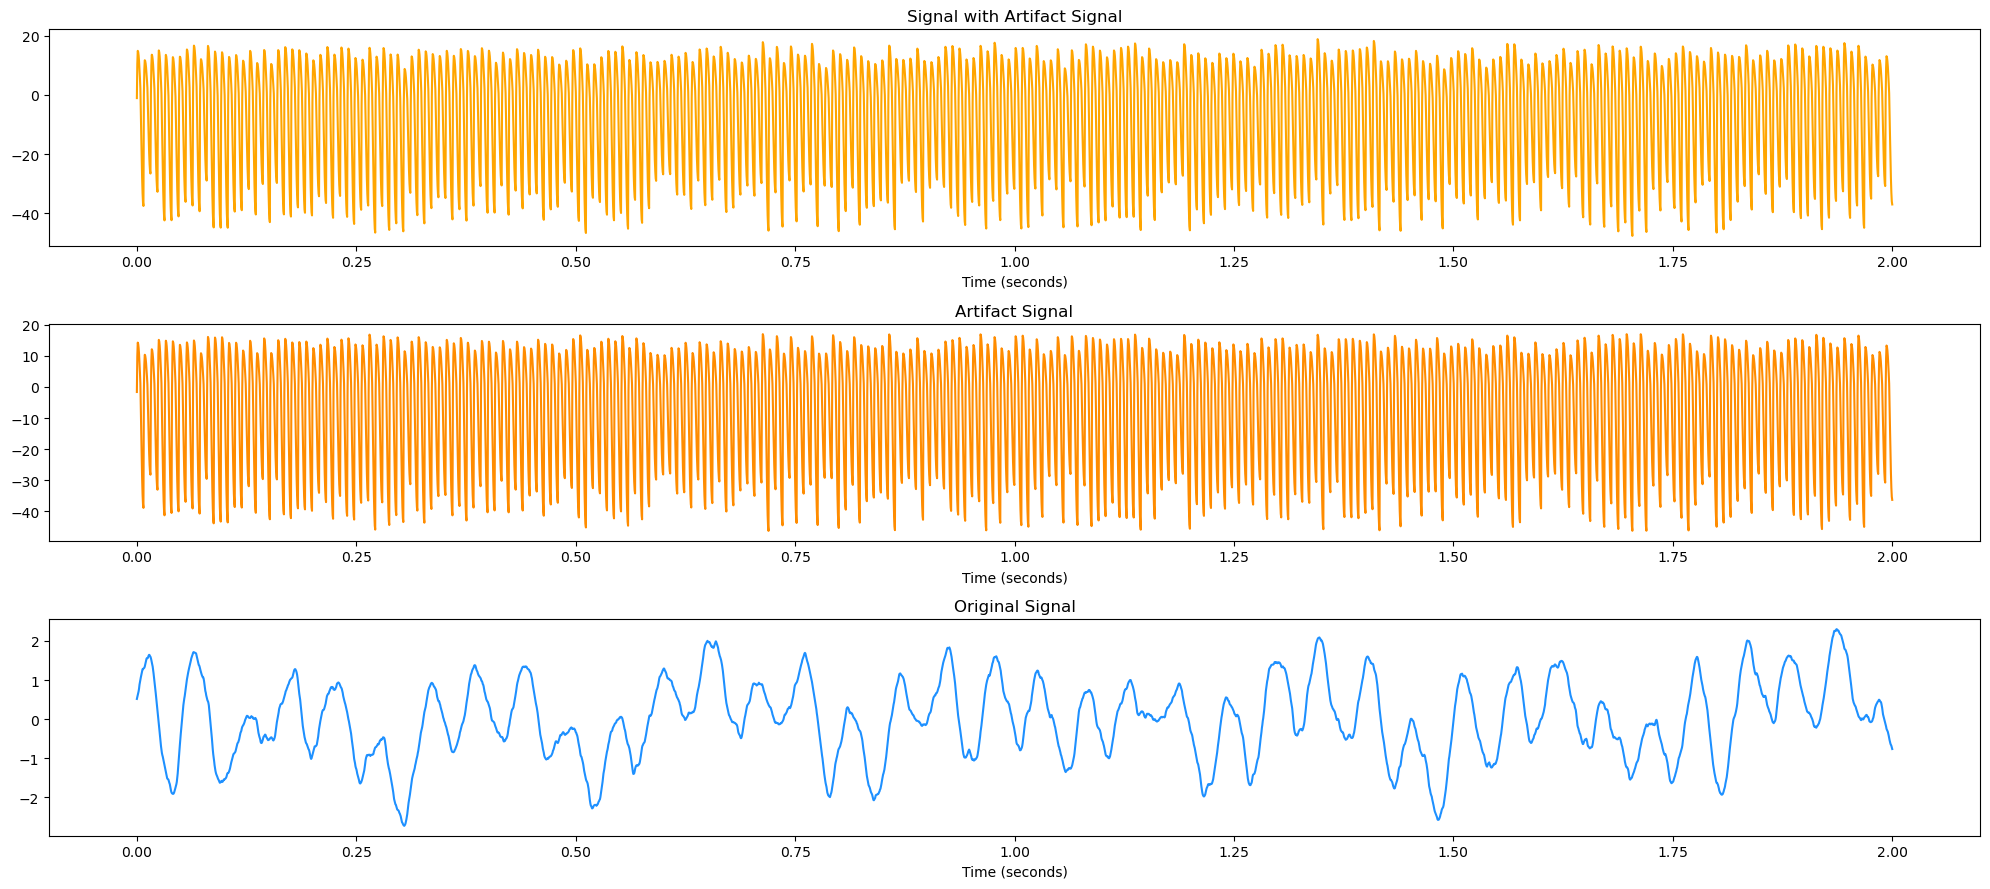

In [3]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,9))
plt.subplot(3, 1, 1)
plt.plot(t, sig_with_artifact[0], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Signal with Artifact Signal')

plt.subplot(3, 1, 2)
plt.plot(t, artifact[0], color='darkorange')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t, sig[0], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Original Signal')

plt.tight_layout()

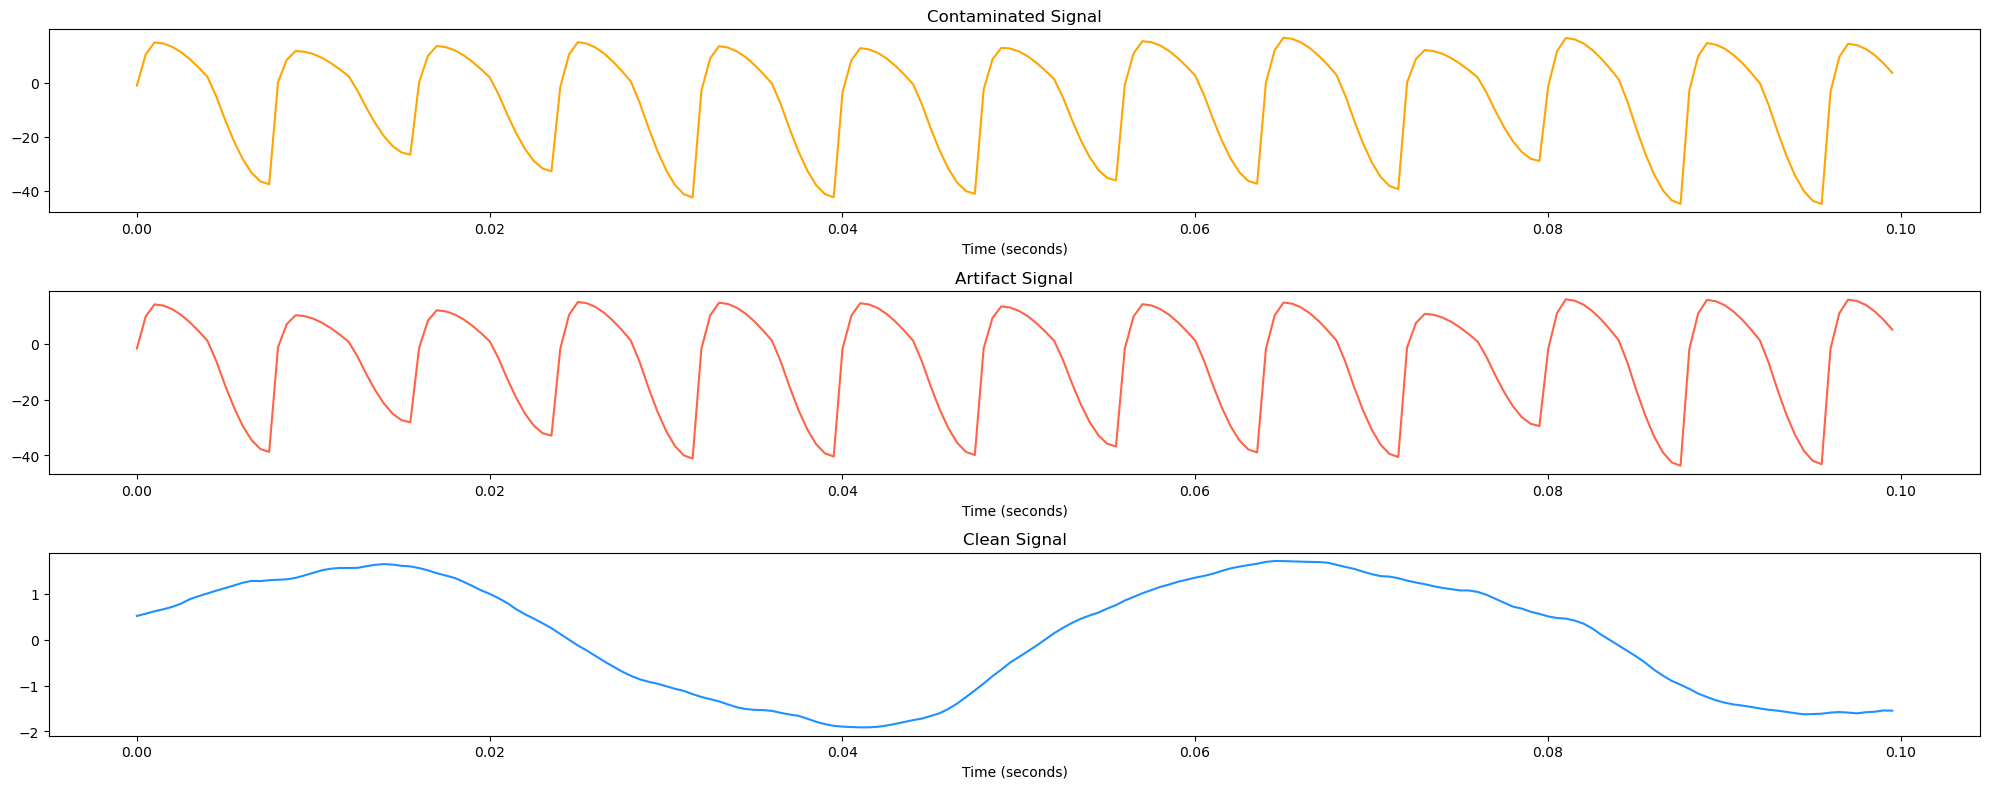

In [4]:
t = np.linspace(0, 2, num=4000) 

plt.figure(figsize=(20,8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], sig_with_artifact[0][:200], color='orange')
plt.xlabel("Time (seconds)")
plt.title('Contaminated Signal')

plt.subplot(3, 1, 2)
plt.plot(t[:200], artifact[0][:200], color='tomato')
plt.xlabel("Time (seconds)")
plt.title('Artifact Signal')

plt.subplot(3, 1, 3)
plt.plot(t[:200], sig[0][:200], color='dodgerblue')
plt.xlabel("Time (seconds)")
plt.title('Clean Signal')

plt.tight_layout()

In [5]:
# 웨이블릿 변환 및 패딩 처리 함수
def wavelet_transform_and_pad(data, wavelet='db1'):
    coeffs = pywt.wavedec(data, wavelet)
    max_len = max(len(c) for c in coeffs)
    padded_coeffs = [np.pad(c, (0, max_len - len(c)), 'constant') for c in coeffs]
    return np.stack(padded_coeffs, axis=0)

wavelet = 'db1'

X_wt = np.array([wavelet_transform_and_pad(sample_X, wavelet) for sample_X in sig_with_artifact])
y_wt = np.array([wavelet_transform_and_pad(sample_y, wavelet) for sample_y in sig])

print("X_wt:", X_wt.shape)
print("y_wt:", y_wt.shape)

X_wt: (1000, 12, 2000)
y_wt: (1000, 12, 2000)


In [6]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

flat_X_wt = X_wt.flatten().reshape(-1, 1)
flat_y_wt = y_wt.flatten().reshape(-1, 1)
scaled_flat_X_wt = scaler_X.fit_transform(flat_X_wt)
scaled_flat_y_wt = scaler_y.fit_transform(flat_y_wt)

X = scaled_flat_X_wt.reshape(X_wt.shape)
y = scaled_flat_y_wt.reshape(y_wt.shape)

print("X:", X.shape)
print("y:", y.shape)

X: (1000, 12, 2000)
y: (1000, 12, 2000)


In [7]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 12, 2000)
y_train shape: (800, 12, 2000)
-----------------------------
X_test shape: (200, 12, 2000)
y_test shape: (200, 12, 2000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 1, 12, 2000)
y_train shape: (800, 12, 2000)
-----------------------------
X_test shape: (200, 1, 12, 2000)
y_test shape: (200, 12, 2000)
-----------------------------


In [8]:
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(CNN2D, self).__init__()
        
        # Encoding path
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Decoding path
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.Conv2d(64, out_channels, kernel_size=1)

        self.gelu = nn.GELU()
        
    def forward(self, x):
        # Encoding
        x1 = self.gelu(self.conv1(x))
        x2 = self.pool(self.gelu(self.conv2(x1)))
        x3 = self.pool(self.gelu(self.conv3(x2)))
        
        # Decoding
        x3_up = self.upconv3(x3)
        x2_up = self.upconv2(x3_up)
        x_out = self.upconv1(x2_up)
        
        return x_out

In [9]:
num_samples = 1000
height = 12
width = 2000
num_epochs = 500

model = CNN2D().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape(targets.shape[0], 1, targets.shape[1], targets.shape[2])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch+1)%1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/500], Loss: 0.9543
Epoch [2/500], Loss: 0.8184
Epoch [3/500], Loss: 0.6377
Epoch [4/500], Loss: 0.5418
Epoch [5/500], Loss: 0.4691
Epoch [6/500], Loss: 0.4082
Epoch [7/500], Loss: 0.3676
Epoch [8/500], Loss: 0.3410
Epoch [9/500], Loss: 0.3230
Epoch [10/500], Loss: 0.3126
Epoch [11/500], Loss: 0.3065
Epoch [12/500], Loss: 0.2985
Epoch [13/500], Loss: 0.2926
Epoch [14/500], Loss: 0.2884
Epoch [15/500], Loss: 0.2824
Epoch [16/500], Loss: 0.2792
Epoch [17/500], Loss: 0.2729
Epoch [18/500], Loss: 0.2706
Epoch [19/500], Loss: 0.2676
Epoch [20/500], Loss: 0.2643
Epoch [21/500], Loss: 0.2614
Epoch [22/500], Loss: 0.2596
Epoch [23/500], Loss: 0.2564
Epoch [24/500], Loss: 0.2516
Epoch [25/500], Loss: 0.2488
Epoch [26/500], Loss: 0.2448
Epoch [27/500], Loss: 0.2415
Epoch [28/500], Loss: 0.2388
Epoch [29/500], Loss: 0.2364
Epoch [30/500], Loss: 0.2331
Epoch [31/500], Loss: 0.2294
Epoch [32/500], Loss: 0.2287
Epoch [33/500], Loss: 0.2253
Epoch [34/500], Loss: 0.2233
Epoch [35/500], Loss: 0

In [20]:
# 모델 평가
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.reshape(targets.shape[0], 1, targets.shape[1], targets.shape[2])
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.5552


In [34]:
# wavelet data를 다시 time domain으로 복원
# (200, 1, 12, 2000)

output = outputs.detach().cpu().numpy()
print(output.shape)

out_coeff = list(np.squeeze(output[0]))

wavelet_len = [2, 2, 4, 8, 16, 32, 63, 125, 250, 500, 1000, 2000]
for row, length in zip(out_coeff, wavelet_len):
    row = row[:length]
    print(len(row), end=" ")


# 역변환하여 시간 신호 복원
out_sig = pywt.waverec(out_coeff, 'db1')

plt.plot(out_sig)


(8, 1, 12, 2000)
[array([ 4.3038769e+00,  6.7574067e+00, -2.6846216e+00, ...,
        7.7544898e-04,  1.5868403e-02,  2.6891381e-03], dtype=float32), array([-1.1061465e+01, -1.7657413e+01,  4.5796003e+00, ...,
        3.7603475e-02, -1.9814111e-02, -4.7184750e-03], dtype=float32), array([-1.5751031e+01,  2.6766600e+01, -3.5153507e+01, ...,
        1.3900474e-03, -1.2154959e-02,  9.3858913e-03], dtype=float32), array([ 1.6519608e+01, -2.5225146e+00,  1.4186663e+01, ...,
        3.0037761e-04, -2.8560534e-03,  2.7139261e-03], dtype=float32), array([ 8.2744236e+00, -1.2647017e+01, -1.0036158e+01, ...,
        6.0700551e-03,  1.8017918e-02, -2.0855911e-02], dtype=float32), array([1.2025563e+00, 4.8574128e+00, 7.6001592e+00, ..., 6.2218010e-03,
       8.4823444e-03, 1.7260842e-02], dtype=float32), array([ 3.2310459e-01, -1.5719203e+01,  3.2251263e+01, ...,
       -4.1321494e-02,  4.9822927e-03,  1.9456580e-02], dtype=float32), array([-1.9083164 ,  2.2942247 ,  0.57219607, ...,  0.04894233,


ValueError: coefficient shape mismatch

outputs

In [ ]:
print(outputs.shape, targets.shape)
plt.figure(figsize=(20,3))
plt.plot(t, targets[0].cpu(), label='target')
plt.plot(t, outputs[0].cpu(), label='output')
plt.legend()

In [ ]:
# 웨이블릿 변환 수행
wavelet = 'db1'  # Daubechies wavelet
coeffs = pywt.wavedec(X[0], wavelet)

c = 1
for i in coeffs:
    print(f"[{c}]: {len(i)}")
    c += 1

# 변환된 웨이블릿 계수 확인
cA = coeffs[0]  # Approximation coefficients
cD = coeffs[1:]  # Detail coefficients

# 웨이블릿 계수 시각화
fig, ax = plt.subplots(len(coeffs), 1, figsize=(6, 18))

for i in range(len(coeffs)):
    ax[i].plot(coeffs[i])
    ax[i].set_title(f'Coefficients at level {i}')

plt.tight_layout()
plt.show()

# 역변환을 통해 원래 데이터 복원
reconstructed_data = pywt.waverec(coeffs, wavelet)

# 원래 데이터와 복원된 데이터 비교
plt.figure(figsize=(10, 5))
plt.plot(t, X[0], label='Original Data')
plt.plot(t, reconstructed_data, label='Reconstructed Data', linestyle='dashed')
plt.legend()
plt.title('Original vs Reconstructed Data')
plt.show()

print(max(abs(X[0] - reconstructed_data)))


In [ ]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, 4000) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x 1 x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

In [ ]:
# time domain plotting

Contaminated_signal = Contaminated[0]
SACed_signal = SACed[0]
Clean_signal = Clean[0]

plt.figure(figsize=(20,8))
plt.subplot(2, 1, 1)
plt.plot(t, Contaminated_signal, label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t, Clean_signal, label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t, SACed_signal, label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('CNN result')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t[:200], Contaminated_signal[:200], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], Clean_signal[:200], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(t[:200], SACed_signal[:200], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('zoom-in')
plt.legend()

plt.tight_layout()

print(f"Mean Absolute Error: {mean_absolute_error(Clean_signal, SACed_signal)}")
print(f"Mean Squared Error: {mean_squared_error(Clean_signal, SACed_signal)}")

In [ ]:
# frequency domain plotting

n = len(SACed_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(SACed_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(Clean_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

fft_nonSACed = np.fft.fft(Contaminated_signal)
fft_nonSACed = np.abs(fft_nonSACed[:n//2])
fft_nonSACed[1:] = 2 * fft_nonSACed[1:]
power_nonSACed = fft_nonSACed**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs[1:600], np.log10(power_nonSACed)[1:600], label='Contaminated Signal', color='orange', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_actual)[1:600], label='Clean Signal', color='dodgerblue', alpha=0.7, linewidth=0.7)
plt.plot(freqs[1:600], np.log10(power_predicted)[1:600], label='SACed Signal', color='red', alpha=0.7, linewidth=0.7)
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.axvline(x=130, color='black', linestyle='--',label='130 Hz', linewidth=0.7)
plt.show()

print(f"Mean Absolute Error: {mean_absolute_error(np.log10(power_predicted), np.log10(power_actual))}")
print(f"Mean Squared Error: {mean_squared_error(np.log10(power_predicted), np.log10(power_actual))}")